# Building a LAS file from scratch

This example shows:

- Creating a pretend/synthetic data curve that we'll call "SYNTH", including some null values
- Creating an empty LASFile object with a default header
- Adding some information to the header
- Adding the synthetic data to the LASFile object
- Writing it to disk as both a LAS version 1.2 and 2.0 file
- Re-loading the file and checking that the null values are interpreted correctly

In [1]:
import lasio

import datetime
import numpy
import os
import matplotlib.pyplot as plt
%matplotlib inline

## Step 1

Create some synthetic data, and make some of the values in the middle null values (``numpy.nan`` specifically). Note that of course every curve in a LAS file is recorded against a reference/index, either depth or time, so we create that array too.

In [2]:
depths = numpy.arange(10, 50, 0.5)
synth = numpy.log10(depths) * 10 + numpy.random.random(len(depths))
synth[15:25] = numpy.nan   # Add some null values in the middle

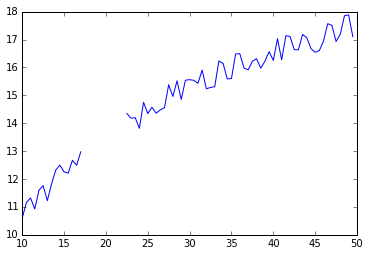

In [3]:
plt.plot(depths, synth)

## Step 2

Create an empty LASFile object and review its header section

In [4]:
l = lasio.LASFile()

In [5]:
l.header

RuntimeError: maximum recursion depth exceeded

Let's add some information to the header: 

- the date
- the operator (in the Parameter section)
- a description of the file in the Other section.

First, let's change the date.

In [ ]:
l.well.DATE = str(datetime.datetime.today())

Next, let's make a new item in the ~Parameters section for the operator. To do this we need to make a new ``HeaderItem``:

In [ ]:
l.params['ENGI'] = lasio.HeaderItem("ENGI", "", "kinverarity@hotmail.com", "Creator of this file...")

And finally, add some free text to the ~Other section:

In [ ]:
l.other = "Example of how to create a LAS file from scratch using las_reader"

## Step 3

Add the curves to the LAS file using the ``add_curve`` method:

In [ ]:
l.add_curve("DEPT", depths, unit="m")
l.add_curve("SYNTH", synth, descr="Synthetic data")

## Step 4

Now let's write out two files: one according to the LAS file specification version 1.2, and one according to 2.0. Note that by default an empty ``LASFile`` object is version 2.0.

In [ ]:
fn = "scratch_example_v2.las"
with open(fn, mode="w") as f: # Write LAS file to disk
    l.write(f)

and let's see if that worked

In [ ]:
with open(fn, mode="r") as f: # Show the result... 
    print(f.read())

In [ ]:
plt.plot(l.DEPT, l.SYNTH)

In [ ]:
os.remove(fn)